##Notebook 4 : Inference & Evaluation

This series of notebooks demonstrates a comparative approach to fake news detection using natural language processing (NLP) techniques. We will use a dataset from Kaggle containing labeled news articles as real or fake.

**Authored by @ Divye Joshi, School of Engineering, JNU**

### Ensuring TensorFlow Version 2.15
This code installs TensorFlow version 2.15.0 and tensorflow-text 2.15.0 using pip. This specific version might be required for compatibility with the code in this notebook. Errors during installation can be ignored.

In [1]:
!pip -q install tensorflow==2.15.0
!pip -q install tensorflow-text==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorstore 0.1.67 requires ml-dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.15.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.4 MB/s eta 0:00:00


### Importing Necessary Libraries
This code imports the required libraries for data processing, model inference and visualization.

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer,tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import gdown

import re
import nltk
import json
import pandas as pd

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Downloading the Trained Models & Tokenizers
This Code downloads the Trained models & Tokenizers using `gdown`. The files is assumed to be made in a previous notebook and is stored in a Google Drive file.

In [3]:
gdown.download_folder("https://drive.google.com/drive/folders/1o2cQk1mjn-hL8fCzzgC86qkz-8CJ3L6J?usp=sharing")
gdown.download_folder("https://drive.google.com/drive/folders/1_9VlvOFwmoejBcuIIjB2MLWbPu1mnujn?usp=sharing")

Retrieving folder contents


Processing file 1n6-Z1nHTR5tEd5IsvrE6LbQ1RRIcf2ow bidirectional-lstm-model.h5
Processing file 12ugzoQ_pRNpIGOrTiwzFQhDhk5_OUzcA tokenizer.json


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1n6-Z1nHTR5tEd5IsvrE6LbQ1RRIcf2ow
To: /content/model-files-case1/bidirectional-lstm-model.h5
100%|██████████| 49.4M/49.4M [00:00<00:00, 78.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=12ugzoQ_pRNpIGOrTiwzFQhDhk5_OUzcA
To: /content/model-files-case1/tokenizer.json
100%|██████████| 3.83M/3.83M [00:00<00:00, 220MB/s]
Download completed
Retrieving folder contents


Processing file 1fd72CiwO-Z7htn6Es7f5BjLOwa8abVA9 finetuned-albert_model.h5


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1fd72CiwO-Z7htn6Es7f5BjLOwa8abVA9
To: /content/model-files-case2/finetuned-albert_model.h5
100%|██████████| 46.9M/46.9M [00:00<00:00, 93.1MB/s]
Download completed


['/content/model-files-case2/finetuned-albert_model.h5']

In [4]:
custom_objects = {'KerasLayer': hub.KerasLayer}
albert_model=tf.keras.models.load_model("model-files-case2/finetuned-albert_model.h5",custom_objects=custom_objects)

with open('model-files-case1/tokenizer.json') as f:
    data = json.load(f)
    tokenizer = tokenizer_from_json(data)

lstm_model = tf.keras.models.load_model('model-files-case1/bidirectional-lstm-model.h5')

In [10]:
def process_text(text,tokenizer):

  lemmatizer = WordNetLemmatizer()
  stop_words = set(stopwords.words('english'))
  text = text.lower()
  text = re.sub(r'\W', ' ', text)
  tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
  query=[' '.join(tokens)]

  max_length = 300
  sequences = tokenizer.texts_to_sequences(query)
  padded_features = pad_sequences(sequences, maxlen=max_length, padding='post')

  return padded_features

def infer(data,bi_tokenizer,bi_model,al_model):

    result=[]
    data_bi=process_text(data,bi_tokenizer)

    result.append(round(bi_model.predict(data_bi)[0][0]))
    result.append(round(al_model.predict([data])[0][0]))

    return result

def bulk_inference(dataset, bi_tokenizer, bi_model, al_model):
    model1_predictions = []
    model2_predictions = []

    for feature in dataset:
        # Get predictions for each model
        predictions = infer(feature, bi_tokenizer, bi_model, al_model)

        # Append predictions to respective lists
        model1_predictions.append(predictions[0])  # Prediction from model 1
        model2_predictions.append(predictions[1])  # Prediction from model 2

    return model1_predictions, model2_predictions


def evaluate(features, labels, bi_tokenizer, bi_model, al_model):
    # Get predictions for both models
    model1_preds, model2_preds = bulk_inference(features, bi_tokenizer, bi_model, al_model)

    # Calculate confusion matrix for both models
    cm_model1 = confusion_matrix(labels, model1_preds)
    cm_model2 = confusion_matrix(labels, model2_preds)

    # Calculate ROC AUC for both models
    roc_auc_model1 = roc_auc_score(labels, model1_preds)
    roc_auc_model2 = roc_auc_score(labels, model2_preds)

    # Plot confusion matrix for Model 1
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.heatmap(cm_model1, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title("Confusion Matrix for Model 1")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    # Plot confusion matrix for Model 2
    plt.subplot(1, 2, 2)
    sns.heatmap(cm_model2, annot=True, fmt='d', cmap='Greens', cbar=False)
    plt.title("Confusion Matrix for Model 2")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    plt.show()

    # Calculate ROC curve for both models
    fpr1, tpr1, _ = roc_curve(labels, model1_preds)
    fpr2, tpr2, _ = roc_curve(labels, model2_preds)

    # Plot ROC curves
    plt.figure()
    plt.plot(fpr1, tpr1, label=f"Model 1 (AUC = {roc_auc_model1:.2f})")
    plt.plot(fpr2, tpr2, label=f"Model 2 (AUC = {roc_auc_model2:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend()
    plt.show()

    # Print other metrics for Model 1
    print("Model 1 Evaluation Metrics:")
    print("Accuracy:", accuracy_score(labels, model1_preds))
    print("Precision:", precision_score(labels, model1_preds))
    print("Recall:", recall_score(labels, model1_preds))
    print("F1 Score:", f1_score(labels, model1_preds))
    print("ROC AUC Score:", roc_auc_model1)

    # Print other metrics for Model 2
    print("\nModel 2 Evaluation Metrics:")
    print("Accuracy:", accuracy_score(labels, model2_preds))
    print("Precision:", precision_score(labels, model2_preds))
    print("Recall:", recall_score(labels, model2_preds))
    print("F1 Score:", f1_score(labels, model2_preds))
    print("ROC AUC Score:", roc_auc_model2)

    # Plot error curves (Accuracy over iterations)
    plt.figure()
    acc_model1 = accuracy_score(labels, model1_preds)
    acc_model2 = accuracy_score(labels, model2_preds)
    plt.plot([1, 2], [acc_model1, acc_model2], marker='o', label="Accuracy")
    plt.title("Error Curves")
    plt.xlabel("Model")
    plt.ylabel("Accuracy")
    plt.xticks([1, 2], ["Model 1", "Model 2"])
    plt.ylim(0, 1)
    plt.legend()
    plt.show()

In [7]:
data=str(heading) + "<break>" + str(context)

1/1 [==============================] - 0s 40ms/step


[1, 0]

In [11]:
import kagglehub
import os

# Create the target directory if it doesn't already exist
os.makedirs('/content/datasets', exist_ok=True)

# List of dataset names
datasets = [
    "saurabhshahane/fake-news-classification",
    "hassanamin/textdb3",
    "vishakhdapat/fake-news-detection"
]

# Download and extract each dataset using kagglehub
for dataset in datasets:
    path = kagglehub.dataset_download(dataset)
    # Move each downloaded dataset to the /content/datasets folder
    !mv {path}/* /content/datasets/
    print(f"Downloaded and moved {dataset} to /content/datasets")

print("All datasets downloaded and stored in /content/datasets")

100%|██████████| 92.1M/92.1M [00:05<00:00, 18.9MB/s]

Extracting files...


Downloaded and moved saurabhshahane/fake-news-classification to /content/datasets


100%|██████████| 11.5M/11.5M [00:01<00:00, 7.12MB/s]

Extracting files...


Downloaded and moved hassanamin/textdb3 to /content/datasets


100%|██████████| 9.37M/9.37M [00:01<00:00, 5.29MB/s]

Extracting files...


Downloaded and moved vishakhdapat/fake-news-detection to /content/datasets
All datasets downloaded and stored in /content/datasets


In [18]:
# Paths to datasets
path1 = "/content/datasets/WELFake_Dataset.csv"
path2 = "/content/datasets/fake_or_real_news.csv"
path3 = "/content/datasets/fake_and_real_news.csv"

# Load datasets and drop duplicates and null rows
d1 = pd.read_csv(path1).dropna().drop_duplicates()
d2 = pd.read_csv(path2).dropna().drop_duplicates()
d3 = pd.read_csv(path3).dropna().drop_duplicates()

# Process d1
feature1 = [(str(title) + "<BREAK>" + str(text)) for title, text in zip(d1['title'], d1['text'])]
label1 = d1['label'].tolist()

# Process d2
feature2 = [(str(title) + "<BREAK>" + str(text)) for title, text in zip(d2['title'], d2['text'])]
label2 = [1 if label == "REAL" else 0 for label in d2['label']]

# Process d3
feature3 = d3['Text'].tolist()
label3 = [1 if label == "Real" else 0 for label in d3['label']]

# Display sizes of the lists
print("feature1:", len(feature1), "label1:", len(label1))
print("feature2:", len(feature2), "label2:", len(label2))
print("feature3:", len(feature3), "label3:", len(label3))

feature1: 71537 label1: 71537
feature2: 6335 label2: 6335
feature3: 9865 label3: 9865


In [27]:
import random

def sample_data(feature1, label1, feature2, label2, feature3, label3, sample_size):
    # Define a helper function to filter lists based on feature length
    def filter_long_features(features, labels, max_len=2500):
        filtered_features = []
        filtered_labels = []
        for feature, label in zip(features, labels):
            if len(feature) <= max_len:
                filtered_features.append(feature)
                filtered_labels.append(label)
        return filtered_features, filtered_labels

    # Filter each feature-label pair
    feature1, label1 = filter_long_features(feature1, label1)
    feature2, label2 = filter_long_features(feature2, label2)
    feature3, label3 = filter_long_features(feature3, label3)

    # Calculate the sample size per feature/label list
    sample_per_list = sample_size // 3  # Divide total samples equally among the 3 lists
    sample_per_label = sample_per_list // 2  # Divide further between label 0 and label 1

    def sample_from_list(features, labels, sample_per_label):
        # Separate indices based on label
        idx_label_0 = [i for i, label in enumerate(labels) if label == 0]
        idx_label_1 = [i for i, label in enumerate(labels) if label == 1]

        # Randomly sample the required number of indices for each label
        sampled_idx_0 = random.sample(idx_label_0, min(sample_per_label, len(idx_label_0)))
        sampled_idx_1 = random.sample(idx_label_1, min(sample_per_label, len(idx_label_1)))

        # Gather the samples using the indices
        sampled_features = [features[i] for i in sampled_idx_0 + sampled_idx_1]
        sampled_labels = [labels[i] for i in sampled_idx_0 + sampled_idx_1]

        return sampled_features, sampled_labels

    # Sample from each feature-label pair
    sampled_features_1, sampled_labels_1 = sample_from_list(feature1, label1, sample_per_label)
    sampled_features_2, sampled_labels_2 = sample_from_list(feature2, label2, sample_per_label)
    sampled_features_3, sampled_labels_3 = sample_from_list(feature3, label3, sample_per_label)

    # Combine all sampled features and labels from each list
    combined_features = sampled_features_1 + sampled_features_2 + sampled_features_3
    combined_labels = sampled_labels_1 + sampled_labels_2 + sampled_labels_3

    return combined_features, combined_labels



1/1 [==============================] - 0s 45ms/step


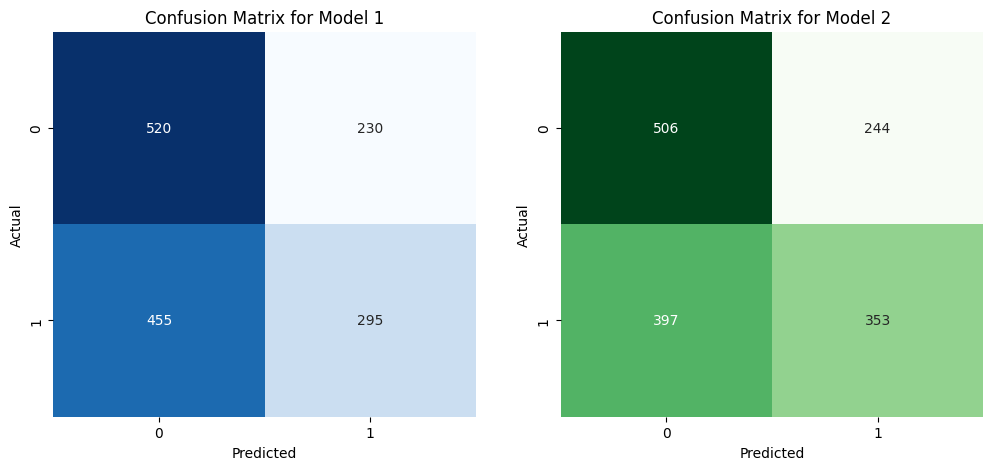

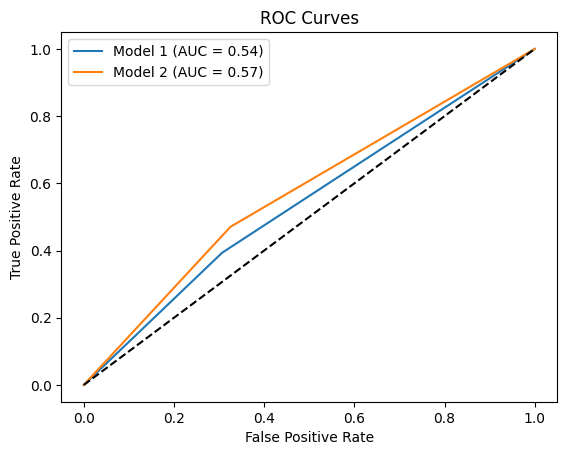

Model 1 Evaluation Metrics:
Accuracy: 0.5433333333333333
Precision: 0.5619047619047619
Recall: 0.3933333333333333
F1 Score: 0.4627450980392157
ROC AUC Score: 0.5433333333333333

Model 2 Evaluation Metrics:
Accuracy: 0.5726666666666667
Precision: 0.5912897822445561
Recall: 0.4706666666666667
F1 Score: 0.5241276911655531
ROC AUC Score: 0.5726666666666668


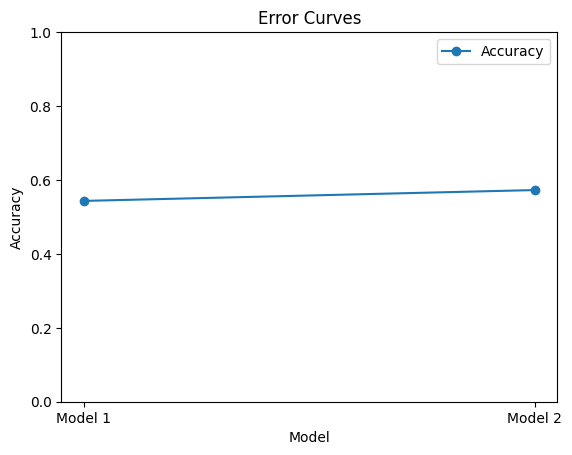

In [28]:
sampled_features, sampled_labels = sample_data(feature1, label1, feature2, label2, feature3, label3, sample_size=1500)
evaluate(sampled_features,sampled_labels,tokenizer,lstm_model,albert_model)

In [24]:
set(sampled_labels)

{0, 1}